In [1]:
import os
import torch
import numpy as np
import tempfile
from contextlib import nullcontext

from mast3r.demo import get_args_parser, main_demo, get_reconstructed_scene, set_scenegraph_options
from dust3r.utils.device import to_numpy


from mast3r.model import AsymmetricMASt3R
from mast3r.utils.misc import hash_md5

import mast3r.utils.path_to_dust3r  # noqa
from dust3r.demo import set_print_with_timestamp

import matplotlib.pyplot as pl

import os
from scipy.io import savemat
import argparse

%load_ext autoreload
%autoreload 2

/mast3r/dust3r/dust3r/cloud_opt/base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [58]:
outdir = "./output"
device = "cpu"
filelist = "./images_in"

#make filelist be a list of all the files in the directory
filelist = [os.path.join(filelist, f) for f in os.listdir(filelist)]
print(filelist)

['./images_in/1.png', './images_in/2.png', './images_in/3.png', './images_in/4.png', './images_in/5.png', './images_in/10.png', './images_in/9.png', './images_in/8.png', './images_in/7.png', './images_in/6.png']


In [5]:
model = AsymmetricMASt3R.from_pretrained("./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth").to(device)

... loading model from ./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


In [136]:
#scenegraphy
win_col, winsize, win_cyclic, refid = set_scenegraph_options(filelist, False, 0, "swin")
winsize = 2
win_cyclic = True

In [137]:
#test make_pairs
from dust3r.image_pairs import make_pairs

scenegraph_type="swin"
scene_graph_params = [scenegraph_type]
if scenegraph_type in ["swin", "logwin"]:
    scene_graph_params.append(str(winsize))
elif scenegraph_type == "oneref":
    scene_graph_params.append(str(refid))
if scenegraph_type in ["swin", "logwin"] and not win_cyclic:
    scene_graph_params.append('noncyclic')
scene_graph = '-'.join(scene_graph_params)

pairs = make_pairs(filelist, scene_graph=scene_graph, prefilter=None, symmetrize=True)

len(pairs)

40

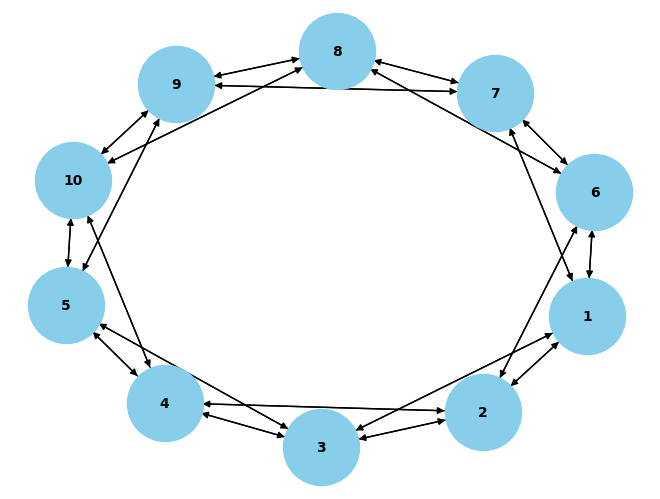

In [140]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
for i, file in enumerate(filelist):
    file = file.split("/")[-1][:-4]
    G.add_node(i, label=file)

# Add edges
for pair in pairs:
    src = filelist.index(pair[0])
    dst = filelist.index(pair[1])
    G.add_edge(src, dst)

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_node_attributes(G, 'label')
nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
pl.show()

In [14]:
scene, _ = get_reconstructed_scene(outdir=outdir,
                                   gradio_delete_cache=False,
                                   model=model,
                                   device=device,
                                   filelist=filelist,
                                   shared_intrinsics=True,
                                   optim_level="refine",
                                   scenegraph_type="complete",
                                   winsize=winsize,
                                   win_cyclic=win_cyclic, 
                                   refid=refid)


#unpack scene
scene = scene.sparse_ga

mask = to_numpy(scene.get_masks())
pts3d, depthmaps, confs = to_numpy(scene.get_dense_pts3d(clean_depth=True))
pts3d_clr = to_numpy(scene.get_pts3d_colors())

rgbimgs = scene.imgs
focals = scene.get_focals().cpu()
cams2world = scene.get_im_poses().cpu()

>> Loading a list of 2 images
 - adding ./images_in/1.png with resolution 256x512 --> 256x512
 - adding ./images_in/2.png with resolution 256x512 --> 256x512
 (Found 2 images)


  0%|                                                                                                                   | 0/2 [00:00<?, ?it/s]/mast3r/mast3r/cloud_opt/sparse_ga.py:646: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitH

init focal (shared) =  380.22


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 60.87it/s, lr=0.0000, loss=0.043]


>> final loss = 0.04270700365304947


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 43.29it/s, lr=0.0000, loss=0.940]
/mast3r/mast3r/cloud_opt/sparse_ga.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitH

>> final loss = 0.9395948648452759
Final focal (shared) =  364.19
(exporting 3D scene to ./output/tmpf_477q91_scene.glb )
